# Spatial Coarse-Graining of TAP and Mean-Field Inference Algorithms

In [1]:
%pylab inline
import sys, importlib
sys.path.append('../code')
from notebookutils import *
# Also import modules using aliases so I can reload them when I make an edit
import notebookutils as ntutils
import tapdynamics as tap
import particlefilter as pfil
importlib.reload(ntutils)
importlib.reload(tap)
importlib.reload(pfil)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<module 'particlefilter' from '/its/home/cg610/coarse_graining_algorithms/coarse_graining_algorithms/notebooks/../code/particlefilter.py'>

### This function is used to create the connectivity matrix J of a Boltzmann machine such that it forms a square lattice

In [2]:
import numpy as np

def square_lattice_J(L):
    """
    Build a symmetric NxN connectivity matrix for a 2D square lattice.

    Parameters
    ----------
    L : int
        Linear lattice size (L x L lattice)

    Returns
    -------
    J : ndarray, shape (N, N)
        Symmetric connectivity matrix with 1 for nearest neighbors
        and 0 on the diagonal
    """
    N = L * L
    J = np.zeros((N, N), dtype=int)

    def idx(x, y):
        return x + L * y

    for x in range(L):
        for y in range(L):
            i = idx(x, y)

            # right neighbor
            if x + 1 < L:
                j = idx(x + 1, y)
                J[i, j] = 1
                J[j, i] = 1

            # up neighbor
            if y + 1 < L:
                j = idx(x, y + 1)
                J[i, j] = 1
                J[j, i] = 1

    return J

### Here, we simulate the updating of marginal beliefs over latent states under both the TAP and mean-field inference algorithms

In [3]:
def get_dynamics(Ns, Nr, Ny, B_train, T): 
    np.random.seed(13)
    ##################
    # These parameters are not used since the connections to observations to latent states are zeroed out                             
    T_low, T_high = T, T+1           # range of time periods for which input is held constant: T and T+1 means constant for entire period
    yG_low, yG_high = np.sqrt(Ns), np.sqrt(Ns)   # These input gains give us binary observations


    # process and observation noise covariance matrices
    q_process, q_obs = 0, 0
    Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

    # filter used for smoothing the input signals
    # Carter changed from signal.hamming to signal.windows.hamming 
    smoothing_filter = signal.windows.hamming(5,sym=True) 
    smoothing_filter = smoothing_filter/sum(smoothing_filter)


    # lam controls how much new messages update activation
    lam = np.array([1])  # No low pass filter
    # The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
    # the exponent of J, x_i, and x_j. 
    G_TAP   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation
    G_MF   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # mean field parameters

    # Connectivity matrix between state nodes
    # Ns x Ns
    J = square_lattice_J(int(np.sqrt(Ns)))
    J = J/np.max(np.abs(np.linalg.eigvals(J)))  # normalize spectral radius to 1 to avoid oscillations of TAP

    # Connectivity matrix between state and observation nodes
    # Ns x Ny
    # if Ns <= Ny:
    #     V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
    # else:
    #     V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]
    V = np.zeros((Ns,Ny))  # No input dependence

    # Empty embedding matrix because we don't care about neural response
    embedding_arr = (Nr,Ns)
    U = np.zeros(embedding_arr)

    # Combine all parameters into single vector
    theta_TAP = np.concatenate([lam, G_TAP, JMatToVec(J), U.flatten('F'), V.flatten('F') ])
    theta_MF = np.concatenate([lam, G_MF, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

    # Put in filler values for unused parameters
    self_coupling_on = False
    sparsity_J = 0.0
    Jtype = 'nonferr'  # full, sparse, or diag

    params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

    ##################
    # Specify sampling or message passing function
    # runTAP - message passing
    # runTAPSampling - sampling
    TAP_func=runTAP
    input = generate_input_binary(B_train, Ny, T-1)
    initial_x = np.random.rand(Ns,B_train) 	
    y_train_TAP, x_train_TAP, r_train_TAP = tap.generate_TAPdynamics(theta_TAP, params, B_train, T, T_low, T_high, yG_low, yG_high,{},{},input,initial_x,TAP_func=TAP_func)
    y_train_MF, x_train_MF, r_train_MF = tap.generate_TAPdynamics(theta_MF, params, B_train, T, T_low, T_high, yG_low, yG_high,{},{},input,initial_x,TAP_func=TAP_func)

    # For validating the inference over G
    G_inferred_MF = tap.infer_exact_G_all_timepoints(y_train_MF, x_train_MF, params,theta_MF) 
    G_inferred_TAP = tap.infer_exact_G_all_timepoints(y_train_TAP, x_train_TAP, params,theta_TAP)

    return y_train_TAP, x_train_TAP, r_train_TAP, y_train_MF, x_train_MF, r_train_MF



Ns=25
Nr=2
Ny=25
B_train=1
T=16
y_train_TAP, x_train_TAP, r_train_TAP, y_train_MF, x_train_MF, r_train_MF = get_dynamics(Ns, Nr, Ny, B_train, T)

### Let's visualize the change in the latent state probability over time

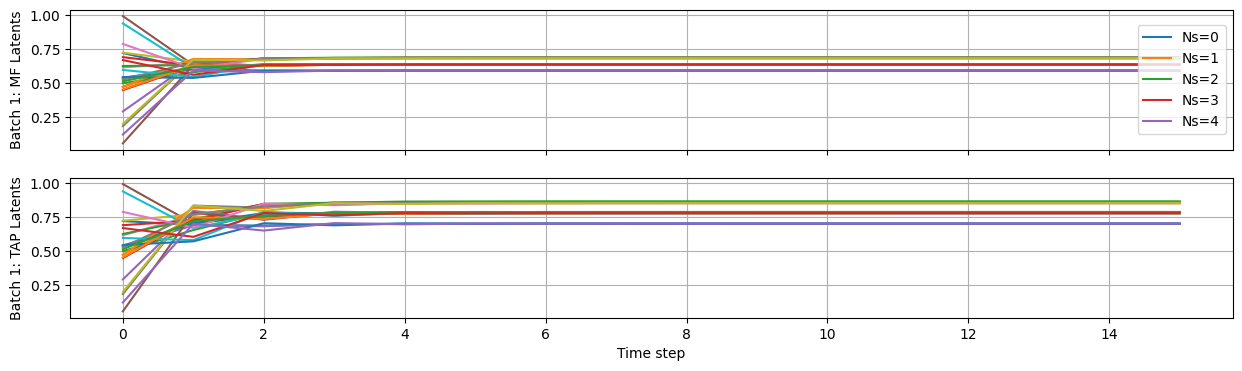

In [4]:
# Plot MF and TAP latent updates
B_to_plot = 2 
B_total, Ns, T = x_train_TAP.shape

fig, axs = plt.subplots(B_to_plot, 1, figsize=(15, 2*B_to_plot), sharex=True)

# Plot MF latents
for n in range(Ns):
    axs[0].plot(x_train_MF[0, n, :], label=f'Ns={n}' if n<5 else None)
axs[0].set_ylabel(f'Batch 1: MF Latents')
axs[0].grid(True)

# Plot TAP latents
for n in range(Ns):
    axs[1].plot(x_train_TAP[0, n, :], label=f'Ns={n}')
axs[1].set_ylabel(f'Batch 1: TAP Latents')
axs[1].grid(True)

axs[-1].set_xlabel('Time step')
axs[0].legend(loc='right')  # show legend only on first plot
plt.show()


## Spatial Coarse-Grain Using Renormalization Group
### See "Criticality and Decimation in the Ising Model for d = 1 and d = 2." Berean-Dutcher, 2021


In [5]:
def get_macro_latents(x_train_MF, x_train_TAP, Ns, Nr, T,estimated_J_coef):
    # Keep only even nodes
    L = int(np.sqrt(Ns))   # L = 5

    assert L * L == Ns, "Ns must be a perfect square"

    B_train = 1
    # 1. reshape to lattice 
    micro_lattice_TAP = x_train_TAP.reshape(B_train, L, L, T)
    micro_lattice_MF = x_train_MF.reshape(B_train, L, L, T)

    # 2. decimate: keep even-even sites
    macro_lattice_TAP = micro_lattice_TAP[:, ::2, ::2, :]
    macro_lattice_MF = micro_lattice_MF[:, ::2, ::2, :]

    macro_TAP = macro_lattice_TAP.reshape(B_train, -1, T)
    macro_MF = macro_lattice_MF.reshape(B_train, -1, T)

    Ns_macro = macro_TAP.shape[1]

    # Infer G on coarse-grained data
    # Fill observatinos with zeros since we don't care about them
    macro_y = np.zeros((B_train, Ns_macro, T-1))
    Ny_macro = Ns_macro
    macro_embedding_arr = (Nr,Ns_macro)
    V = np.zeros((Ns_macro,Ny_macro))  # No input dependence

    # Make coarse-grained coupling matrix
    J_macro = square_lattice_J(int(np.sqrt(Ns_macro))) * estimated_J_coef

    
    U_macro = np.zeros(macro_embedding_arr)

    # lam controls how much new messages update activation
    lam = np.array([1])  # No low pass filter
    # The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
    # the exponent of J, x_i, and x_j. 
    G_TAP   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation
    G_MF   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # mean field parameters

    macro_theta_TAP= np.concatenate([lam, G_TAP, JMatToVec(J_macro), U_macro.flatten('F'), V.flatten('F') ])
    macro_theta_MF = np.concatenate([lam, G_MF, JMatToVec(J_macro), U_macro.flatten('F'), V.flatten('F') ])

    # Filler values for unused parameters
    q_process, q_obs = 0, 0
    Q_process, Q_obs = q_process*np.eye(Ns_macro), q_obs*np.eye(Nr)   
    smoothing_filter = signal.windows.hamming(5,sym=True) 
    smoothing_filter = smoothing_filter/sum(smoothing_filter)
 

    macro_params = {'Ns':Ns_macro,'Ny':Ny_macro,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns_macro),'smoothing_filter':smoothing_filter,'self_coupling_on':0,'sparsity_J':.5,'Jtype':"nonferr"  }

    return macro_TAP, macro_MF, macro_theta_TAP, macro_theta_MF, macro_y, macro_params

In [6]:
# Estimate J on coarse-grained lattice keeping only even nodes
J = square_lattice_J(int(np.sqrt(Ns)))
J = J/np.max(np.abs(np.linalg.eigvals(J)))  # normalize spectral radius to 1 to avoid oscillations of TAP
# First get the coupling coefficient
J_coef = max(np.unique(J))
# Estimate J using the formula derived for 2D lattice
# using Migdal-Kadanoff approximation
estimated_J_coef = .5*np.log(np.cosh(4*J_coef))


macro_TAP, macro_MF, macro_theta_TAP, macro_theta_MF, macro_y, macro_params = get_macro_latents(x_train_MF, x_train_TAP, Ns, Nr, T,estimated_J_coef)

G_coarse_inferred_TAP = tap.infer_exact_G_all_timepoints(macro_y, macro_TAP, macro_params,macro_theta_TAP)
G_coarse_inferred_MF = tap.infer_exact_G_all_timepoints(macro_y, macro_MF, macro_params,macro_theta_MF)


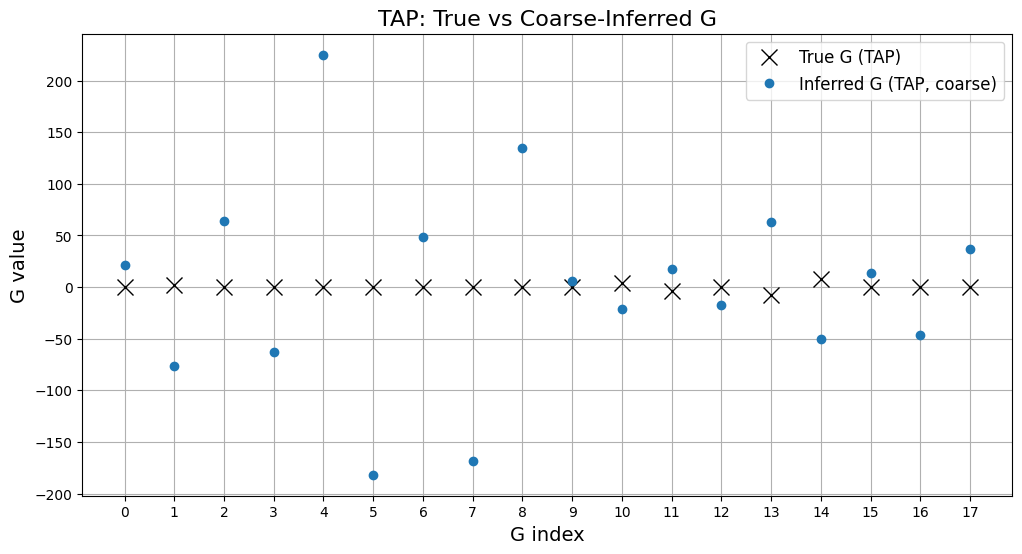

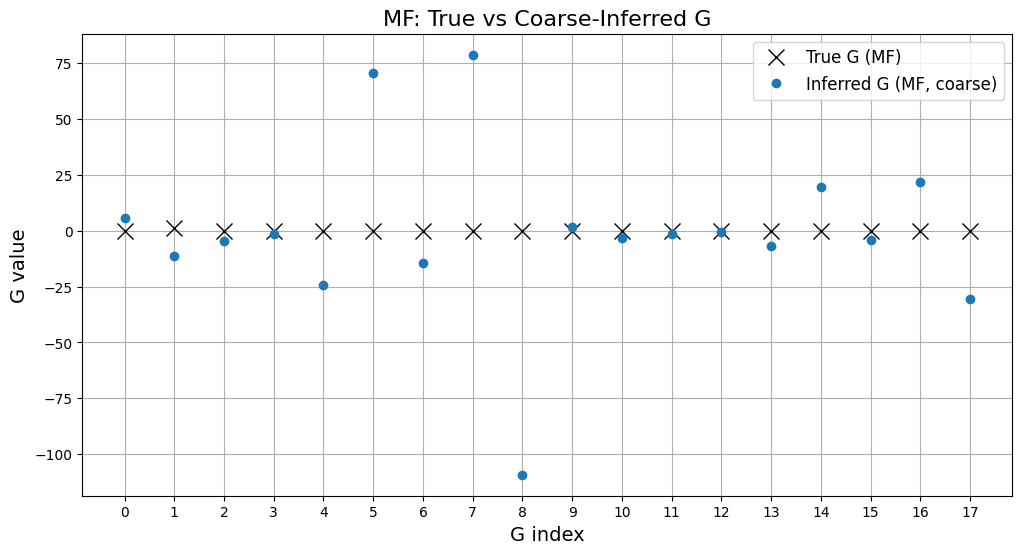

In [7]:
# Plot results!
import matplotlib.pyplot as plt
import numpy as np

G_TAP   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation
G_MF   = np.array([0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # mean field parameters


# Extract vectors (assume batch dimension = 1)
G_inf_TAP = G_coarse_inferred_TAP[0]
G_true_TAP = G_TAP[0] if G_TAP.ndim == 2 else G_TAP

x = np.arange(len(G_true_TAP))

plt.figure(figsize=(12, 6))

plt.plot(x, G_true_TAP, 'x', markersize=12,color="black", label="True G (TAP)")
plt.plot(x, G_inf_TAP, '.', markersize=12, label="Inferred G (TAP, coarse)")

plt.xlabel("G index", fontsize=14)
plt.ylabel("G value", fontsize=14)
plt.title("TAP: True vs Coarse-Inferred G", fontsize=16)

plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(x)

plt.show()

# Extract vectors
G_inf_MF = G_coarse_inferred_MF[0]
G_true_MF = G_MF[0] if G_MF.ndim == 2 else G_MF

x = np.arange(len(G_true_MF))

plt.figure(figsize=(12, 6))

plt.plot(x, G_true_MF, 'x', markersize=12, color="black",label="True G (MF)")
plt.plot(x, G_inf_MF, '.', markersize=12, label="Inferred G (MF, coarse)")

plt.xlabel("G index", fontsize=14)
plt.ylabel("G value", fontsize=14)
plt.title("MF: True vs Coarse-Inferred G", fontsize=16)

plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(x)

plt.show()



## Repeat this analysis on a bigger lattice

In [8]:
Ns=441
Nr=2
Ny=441
B_train=1
T=16
y_train_TAP, x_train_TAP, r_train_TAP, y_train_MF, x_train_MF, r_train_MF = get_dynamics(Ns, Nr, Ny, B_train, T)

# Estimate J on coarse-grained lattice keeping only even nodes
J = square_lattice_J(int(np.sqrt(Ns)))
J = J/np.max(np.abs(np.linalg.eigvals(J)))  # normalize spectral radius to 1 to avoid oscillations of TAP
# First get the coupling coefficient
J_coef = max(np.unique(J))
# Estimate J using the formula derived for 2D lattice
# using Migdal-Kadanoff approximation
estimated_J_coef = .5*np.log(np.cosh(4*J_coef))


macro_TAP, macro_MF, macro_theta_TAP, macro_theta_MF, macro_y, macro_params = get_macro_latents(x_train_MF, x_train_TAP, Ns, Nr, T,estimated_J_coef)

G_coarse_inferred_TAP = tap.infer_exact_G_all_timepoints(macro_y, macro_TAP, macro_params,macro_theta_TAP)
G_coarse_inferred_MF = tap.infer_exact_G_all_timepoints(macro_y, macro_MF, macro_params,macro_theta_MF)
print("Coarse-grained inferred G (TAP): ", G_coarse_inferred_TAP[0])
print("Coarse-grained inferred G (MF): ", G_coarse_inferred_MF[0])


Coarse-grained inferred G (TAP):  [  2.88867787  -5.63406267   3.89567424  -7.18497747  29.67681199
 -23.7629259    4.50866582 -24.51986011  22.83977325   0.63787
  -1.24409841   0.8602322   -1.5865672    6.55315298  -5.24726472
   0.99559133  -5.41440888   5.04341666]
Coarse-grained inferred G (MF):  [ 1.34353696 -2.76473354  1.93126402 -3.04016579 11.12704745 -7.73869549
  1.9137534  -6.61183122  4.2260332   0.29667618 -0.61050095  0.42645647
 -0.67132115  2.45704438 -1.70883771  0.42258982 -1.4600066   0.93318117]


## Plot

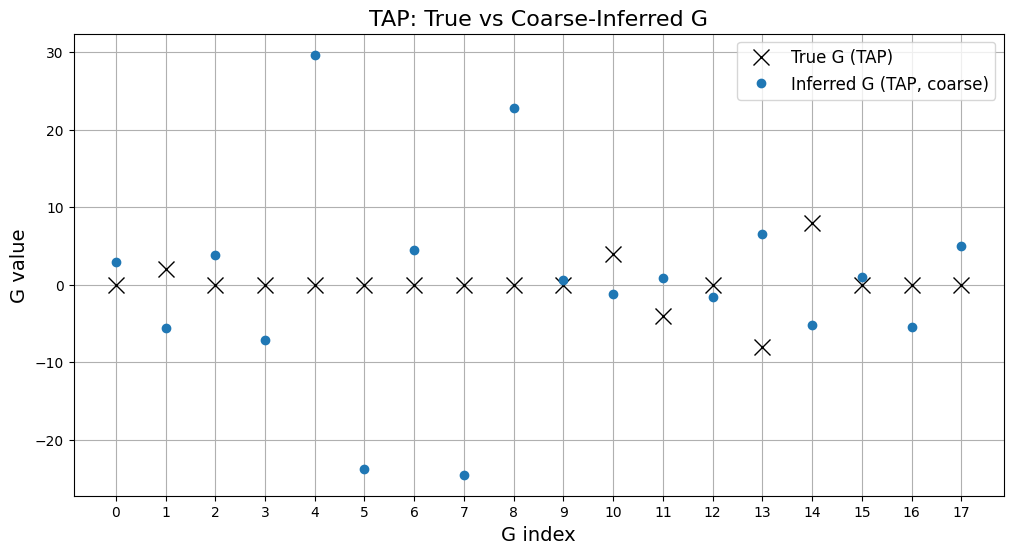

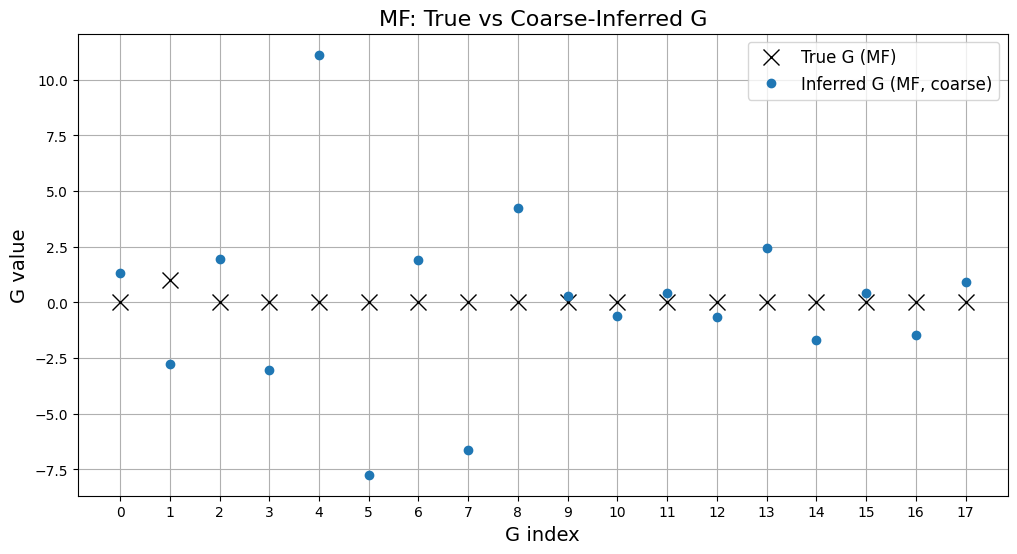

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Extract vectors (assume batch dimension = 1)
G_inf_TAP = G_coarse_inferred_TAP[0]
G_true_TAP = G_TAP[0] if G_TAP.ndim == 2 else G_TAP

x = np.arange(len(G_true_TAP))

plt.figure(figsize=(12, 6))

plt.plot(x, G_true_TAP, 'x', markersize=12,color="black", label="True G (TAP)")
plt.plot(x, G_inf_TAP, '.', markersize=12, label="Inferred G (TAP, coarse)")

plt.xlabel("G index", fontsize=14)
plt.ylabel("G value", fontsize=14)
plt.title("TAP: True vs Coarse-Inferred G", fontsize=16)

plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(x)

plt.show()

# Extract vectors
G_inf_MF = G_coarse_inferred_MF[0]
G_true_MF = G_MF[0] if G_MF.ndim == 2 else G_MF

x = np.arange(len(G_true_MF))

plt.figure(figsize=(12, 6))

plt.plot(x, G_true_MF, 'x', markersize=12, color="black",label="True G (MF)")
plt.plot(x, G_inf_MF, '.', markersize=12, label="Inferred G (MF, coarse)")

plt.xlabel("G index", fontsize=14)
plt.ylabel("G value", fontsize=14)
plt.title("MF: True vs Coarse-Inferred G", fontsize=16)

plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(x)

plt.show()



## Loop through lattice sizes and apply spatial coarse-graining

In [10]:
odd_integers = list(range(5, 52, 2))

G_TAP_by_N = {}
G_MF_by_N  = {}

for lattice_size in odd_integers:
    Ns = lattice_size**2
    Nr=2
    Ny=Ns
    B_train=1
    T=16
    y_train_TAP, x_train_TAP, r_train_TAP, y_train_MF, x_train_MF, r_train_MF = get_dynamics(Ns, Nr, Ny, B_train, T)

    # Estimate J on coarse-grained lattice keeping only even nodes
    J = square_lattice_J(int(np.sqrt(Ns)))
    J = J/np.max(np.abs(np.linalg.eigvals(J)))  # normalize spectral radius to 1 to avoid oscillations of TAP
    # First get the coupling coefficient
    J_coef = max(np.unique(J))
    # Estimate J using the formula derived for 2D lattice
    # using Migdal-Kadanoff approximation
    estimated_J_coef = .5*np.log(np.cosh(4*J_coef))


    macro_TAP, macro_MF, macro_theta_TAP, macro_theta_MF, macro_y, macro_params = get_macro_latents(x_train_MF, x_train_TAP, Ns, Nr, T,estimated_J_coef)

    G_coarse_inferred_TAP = tap.infer_exact_G_all_timepoints(macro_y, macro_TAP, macro_params,macro_theta_TAP)
    G_coarse_inferred_MF = tap.infer_exact_G_all_timepoints(macro_y, macro_MF, macro_params,macro_theta_MF)
    G_TAP_by_N[Ns] = G_coarse_inferred_TAP
    G_MF_by_N[Ns]  = G_coarse_inferred_MF





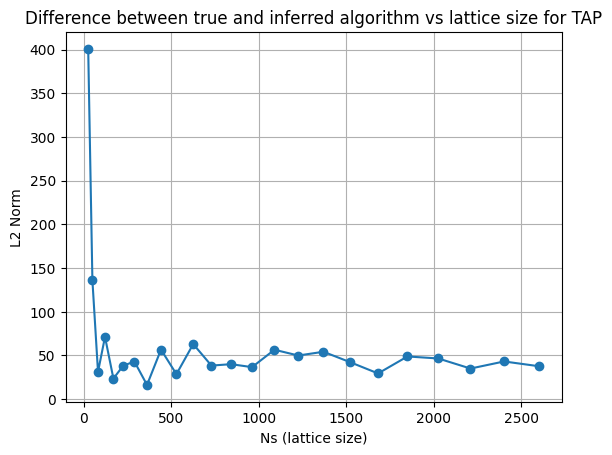

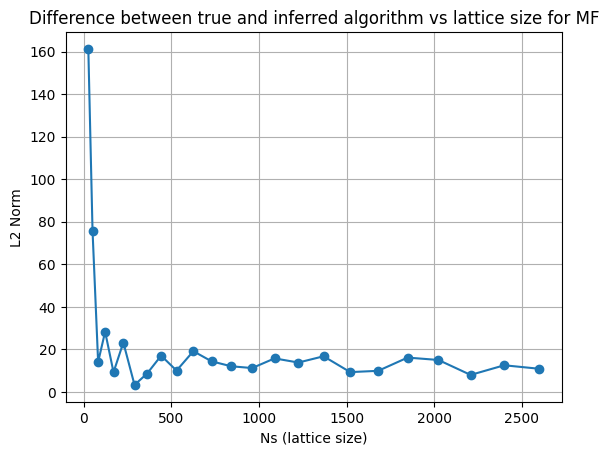

In [11]:
# Plot the difference between true and inferred G values as a function of Ns
import numpy as np

Ns_vals = sorted(G_TAP_by_N.keys())

TAP_err = []
MF_err  = []

for Ns in Ns_vals:
    G_TAP_tuple = G_TAP_by_N[Ns]
    G_MF_tuple  = G_MF_by_N[Ns]

    # Frobenius norm across all timepoints
    TAP_norm = np.linalg.norm(G_TAP_tuple[0]-G_true_TAP,2)
    MF_norm  = np.linalg.norm(G_MF_tuple[0]-G_true_MF,2)

    TAP_err.append(TAP_norm)
    MF_err.append(MF_norm)




plt.figure()
plt.plot(Ns_vals, TAP_err, marker='o')
plt.xlabel("Ns (lattice size)")
plt.ylabel("L2 Norm")
plt.title("Difference between true and inferred algorithm vs lattice size for TAP")
plt.grid(True)
plt.show()



plt.figure()
plt.plot(Ns_vals, MF_err, marker='o')
plt.xlabel("Ns (lattice size)")
plt.ylabel("L2 Norm")
plt.title("Difference between true and inferred algorithm vs lattice size for MF")
plt.grid(True)
plt.show()


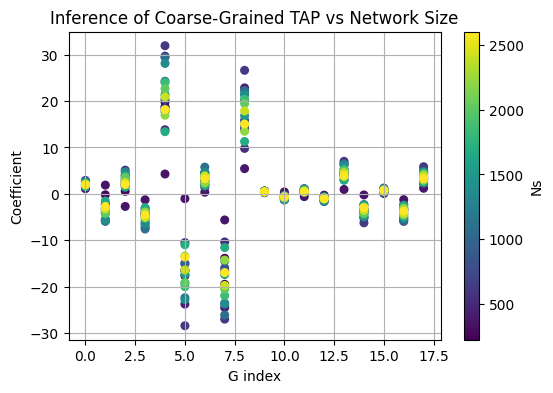

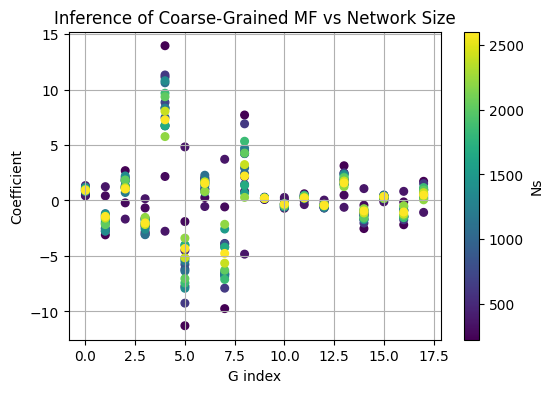

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))

Ns_plot = Ns_vals[5:]
norm = plt.Normalize(vmin=min(Ns_plot), vmax=max(Ns_plot))
cmap = plt.cm.viridis

for Ns in Ns_plot:
    G = G_TAP_by_N[Ns][0]
    G_vec = G.flatten()
    idx = np.arange(len(G_vec))

    # IMPORTANT: use c= with an array, not color=
    plt.scatter(idx, G_vec, s=30, c=[Ns]*len(idx), cmap=cmap, norm=norm)

plt.colorbar(label="Ns")

plt.xlabel("G index")
plt.ylabel("Coefficient")
plt.title("Inference of Coarse-Grained TAP vs Network Size")
plt.grid(True)
plt.show()



####### Plot MF coarse operator spectra vs index for different Ns

plt.figure(figsize=(6,4))

Ns_plot = Ns_vals[5:]
norm = plt.Normalize(vmin=min(Ns_plot), vmax=max(Ns_plot))
cmap = plt.cm.viridis

for Ns in Ns_plot:
    G = G_MF_by_N[Ns][0]
    G_vec = G.flatten()
    idx = np.arange(len(G_vec))

    # IMPORTANT: use c= with an array, not color=
    plt.scatter(idx, G_vec, s=30, c=[Ns]*len(idx), cmap=cmap, norm=norm)

plt.colorbar(label="Ns")

plt.xlabel("G index")
plt.ylabel("Coefficient")
plt.title("Inference of Coarse-Grained MF vs Network Size")
plt.grid(True)
plt.show()
